In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle
import json
import numpy as np
from features import merge_entries
from utills import chunker, cartesian_product
import glob
from tqdm.auto import trange, tqdm

In [3]:
from plotly.offline import init_notebook_mode
import plotly.offline as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [4]:
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.style as style
from matplotlib import rcParams
%matplotlib notebook
style.use('seaborn-whitegrid')


In [6]:
COMPUTED_DATA_PATH = '../temp_data/ai/'
MODEL_DIR = '../temp_data/pan/'
PAN_MODEL_PATH = '../../pan2021/authorship_verification/temp_data/large_model_training_data/large_model.p'

In [7]:
def predict(docs_1, docs_2, clf_nc, transformer_nc, scaler_nc, secondary_scaler_nc, clf, transformer, scaler, secondary_scaler, chunk_sz):
    probs_nc = []

    inter_probs_mean = []
    inter_probs_std = []

    intraA_probs_mean = []
    intraA_probs_std = []

    intraB_probs_mean = []
    intraB_probs_std = []
    pred_lengths = []

    for i in trange(len(docs_1)):
        doc_1 = docs_1[i]
        doc_2 = docs_2[i]
        l = []
        docs_merged_1 = [merge_entries(c) for c in list(chunker(doc_1, chunk_sz))]
        docs_merged_2 = [merge_entries(c) for c in list(chunker(doc_2, chunk_sz))]

        X_1 = scaler.transform(transformer.transform(docs_merged_1).todense())
        X_2 = scaler.transform(transformer.transform(docs_merged_2).todense())

        idxs = cartesian_product(range(len(X_1)), range(len(X_2)))
        x_diff = secondary_scaler.transform(np.abs(X_1[idxs[:, 0]] - X_2[idxs[:, 1]]))
        x_diff[np.isnan(x_diff)]=0
        p = clf.predict_proba(x_diff)[:, 1]

        inter_probs_mean.append(p.mean())
        inter_probs_std.append(p.std())
        l.append(len(p))

        idxs = cartesian_product(range(len(X_1)), range(len(X_1)))
        idxs = np.array([(i, j) for i, j in idxs if i != j])
        if len(idxs) > 0:
            x_diff = secondary_scaler.transform(np.abs(X_1[idxs[:, 0]] - X_1[idxs[:, 1]]))
            x_diff[np.isnan(x_diff)]=0
            p = clf.predict_proba(x_diff)[:, 1]
            intraA_probs_mean.append(p.mean())
            intraA_probs_std.append(p.std())
            l.append(len(p))
        else:
            intraA_probs_mean.append(np.nan)
            intraA_probs_std.append(np.nan)
            l.append(0)

        idxs = cartesian_product(range(len(X_2)), range(len(X_2)))
        idxs = np.array([(i, j) for i, j in idxs if i != j])
        if len(idxs) > 0:
            x_diff = secondary_scaler.transform(np.abs(X_2[idxs[:, 0]] - X_2[idxs[:, 1]]))
            x_diff[np.isnan(x_diff)]=0
            p = clf.predict_proba(x_diff)[:, 1]
            intraB_probs_mean.append(p.mean())
            intraB_probs_std.append(p.std())
            l.append(len(p))
        else:
            intraB_probs_mean.append(np.nan)
            intraB_probs_std.append(np.nan)
            l.append(0)

        pred_lengths.append(l)


        X_1 = scaler_nc.transform(transformer_nc.transform([merge_entries(doc_1)]).todense())
        X_2 = scaler_nc.transform(transformer_nc.transform([merge_entries(doc_2)]).todense())
        p = clf_nc.predict_proba(secondary_scaler_nc.transform(np.abs(X_1 - X_2)))[0, 1]
        probs_nc.append(p)


    inter_probs_mean = np.array(inter_probs_mean)
    intraA_probs_mean = np.array(intraA_probs_mean)
    intraB_probs_mean = np.array(intraB_probs_mean)
    inter_probs_std = np.array(inter_probs_std)
    intraA_probs_std = np.array(intraA_probs_std)
    intraB_probs_std = np.array(intraB_probs_std)
    pred_lengths = np.array(pred_lengths)


    probs_nc = np.array(probs_nc)

    n_a = pred_lengths[:, 0]
    n_b = pred_lengths[:, 1]
    n_ab = pred_lengths[:, 2]

    intra_probs_mean = (intraA_probs_mean * n_a + intraB_probs_mean * n_b)/ (n_a + n_b)
    intra_probs_std = (
            n_a * (intraA_probs_std ** 2 + (intraA_probs_mean - intra_probs_mean)**2) + 
            n_b * (intraB_probs_std ** 2 + (intraB_probs_mean - intra_probs_mean)**2)
        ) / (n_a + n_b)


    pooled_mean = (intra_probs_mean * (n_a + n_b) + inter_probs_mean * n_ab)/ (n_a + n_b + n_ab)
    pooled_std = (
            (n_a + n_b) * (intra_probs_mean ** 2 + (intra_probs_mean - pooled_mean)**2) + 
            n_ab * (inter_probs_mean ** 2 + (inter_probs_mean - pooled_mean)**2)
        ) / (n_a + n_b + n_ab)

    aggr_score = probs_nc * (1 - np.abs(inter_probs_mean - intra_probs_mean))
    return aggr_score

In [8]:
def predict_pan(docs_1, docs_2, clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan):
    docs_merged_1 = [merge_entries(c) for c in docs_1]
    docs_merged_2 = [merge_entries(c) for c in docs_2]
    
    X_1 = scaler_pan.transform(transformer_pan.transform(docs_merged_1).todense())
    X_2 = scaler_pan.transform(transformer_pan.transform(docs_merged_2).todense())
    
    p = clf_pan.predict_proba(secondary_scaler_pan.transform(np.abs(X_1 - X_2)))[:, 1]
    return p

Load Data
===

In [9]:
human_docs_1 = []
human_docs_2 = []
ai_docs_1 = []
ai_docs_2 = []

pair_ids = []
for fname in glob.glob(COMPUTED_DATA_PATH + 'human_ai_preprocessed*.jsonl'):
    with open(fname, 'r') as f:
        for l in f:
            d = json.loads(l)
            human_docs_1.append(d['pair'][0]['human'])
            human_docs_2.append(d['pair'][1]['human'])
            
            ai_docs_1.append(d['pair'][0]['ai'])
            ai_docs_2.append(d['pair'][1]['ai'])
            pair_ids.append(d['id'])
print('Read:', len(human_docs_1))

Read: 97


In [10]:
GROUND_TRUTH_PATH = '../data/pan/pan20-authorship-verification-training-large-truth.jsonl'
ground_truth = {}
with open(GROUND_TRUTH_PATH, 'r') as f:
    for l in f:
        d = json.loads(l)
        ground_truth[d['id']] = d['same']
        
test_docs_1 = []
test_docs_2 = []
labels = []
with open('../temp_data/pan/preprocessed_test.jsonl', 'r') as f:
    for l in f:
#         if np.random.rand() > 0.005:
#             continue
        d = json.loads(l)
        if d['id'] not in pair_ids:
            continue

        test_docs_1.append(d['pair'][0])
        test_docs_2.append(d['pair'][1])
        labels.append(ground_truth[d['id']])
        if len(test_docs_1) == len(pair_ids):
            break
            
print('Read:', len(human_docs_1))

Read: 97


In [82]:
labels = np.array(labels)

Load Models
===

In [11]:
with open(MODEL_DIR + 'model.p', 'rb') as f:
    (clf_nc, transformer_nc, scaler_nc, secondary_scaler_nc) = pickle.load(f)

# Chunked model
with open(MODEL_DIR + 'split_models/model_5.p', 'rb') as f:
    (clf, transformer, scaler, secondary_scaler) = pickle.load(f)
chunk_sz=5

In [12]:
with open(PAN_MODEL_PATH, 'rb') as f:
    (clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan) = pickle.load(f)

Stats
====

In [49]:
print('Human text tokens:', np.mean([len(merge_entries(d)['tokens']) for d in (human_docs_1 + human_docs_2)]))
print('AI text tokens:', np.mean([len(merge_entries(d)['tokens']) for d in (ai_docs_1 + ai_docs_2)]))

Human text tokens: 4943.666666666667
AI text tokens: 4632.017857142857


Predict
===

Baseline - Human vs Human Prediction
----

In [174]:
probs_hh = predict_pan(
    [d[:20] for d in test_docs_1], 
    [d[:20] for d in test_docs_2], 
    clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan
)


fpr, tpr, thresh = roc_curve(labels, probs_hh)
auc(fpr, tpr), probs_hh[labels==True].mean()

(0.9405716416717722, 0.3066404961061369)

In [86]:
probs_test = predict_pan(
    test_docs_1, test_docs_2,
    clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan
)
probs_test[labels==True].mean()

0.7461192783388289

In [13]:
probs_hh = predict_pan(
    human_docs_1, human_docs_2,
    clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan
)
probs_hh.mean()

0.7474558348087242

In [35]:
(probs_hh > 0.5).mean()

0.8

In [42]:
(probs_hh > 0.5).mean()

0.8

In [24]:
probs_hh = predict(
    human_docs_1, human_docs_2,
    clf_nc, transformer_nc, scaler_nc, secondary_scaler_nc,
    clf, transformer, scaler, secondary_scaler, chunk_sz
)
probs_hh.mean()

0.6668897869039725

Human vs AI generated from the same author
---

In [14]:
# probs_ha1 = predict(
#     human_docs_1, ai_docs_1,
#     clf_nc, transformer_nc, scaler_nc, secondary_scaler_nc,
#     clf, transformer, scaler, secondary_scaler, chunk_sz
# )
# probs_ha1.mean()

probs_ha1 = predict_pan(
    human_docs_1, ai_docs_1,
    clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan
)
probs_ha1.mean()

0.10352307048517884

In [15]:
probs_ha2 = predict_pan(
    human_docs_2, ai_docs_2,
    clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan
)
probs_ha2.mean()

0.1253919089744921

In [25]:
probs_ha = np.concatenate([probs_ha1, probs_ha2])
probs_ha.mean()

0.11445748972983547

In [27]:
probs_ha2 = predict(
    human_docs_2, ai_docs_2,
    clf_nc, transformer_nc, scaler_nc, secondary_scaler_nc,
    clf, transformer, scaler, secondary_scaler, chunk_sz
)
probs_ha2.mean()

0.06111632374650812

In [43]:
(probs_ha1 > 0.5).mean()

0.0

AI vs AI, based on texts generated from the same human author
----

In [60]:
# probs_aa = predict(
#     ai_docs_1, ai_docs_2,
#     clf_nc, transformer_nc, scaler_nc, secondary_scaler_nc,
#     clf, transformer, scaler, secondary_scaler, chunk_sz
# )
# probs_aa.mean()

probs_aa = predict_pan(
    ai_docs_1, ai_docs_2,
    clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan
)
probs_aa.mean()

0.9723247887729408

In [44]:
(probs_aa > 0.5).mean()

1.0

AI vs AI, based on texts generated from different human authors
----

In [29]:
# shuffled_idxs = np.random.permutation(len(ai_docs_1))
# probs_aa_shuffled = predict(
#     np.array(ai_docs_1)[shuffled_idxs], np.array(ai_docs_2),
#     clf_nc, transformer_nc, scaler_nc, secondary_scaler_nc,
#     clf, transformer, scaler, secondary_scaler, chunk_sz
# )
# probs_aa_shuffled.mean()

shuffled_idxs = np.random.permutation(len(ai_docs_1))
probs_aa_shuffled = predict_pan(
    np.array(ai_docs_1)[shuffled_idxs], np.array(ai_docs_2),
    clf_pan, transformer_pan, scaler_pan, secondary_scaler_pan
)
probs_aa_shuffled.mean()

0.9155225719215432

In [67]:
fig = go.Figure()
fig.add_trace(go.Histogram(
        x=probs_hh,
        name='H-H',
        nbinsx=10,
        histnorm='probability'
    ))

fig.add_trace(go.Histogram(
        x=probs_ha1,
        name='H-A',
        nbinsx=10,
        histnorm='probability'
    ))

fig.add_trace(go.Histogram(
        x=probs_aa,
        name='A-A',
        nbinsx=10,
        histnorm='probability'
    ))

fig.add_trace(go.Histogram(
        x=probs_aa_shuffled,
        name='A-A(shuffled)',
        nbinsx=10,
        histnorm='probability'
    ))

fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

<IPython.core.display.Javascript object>


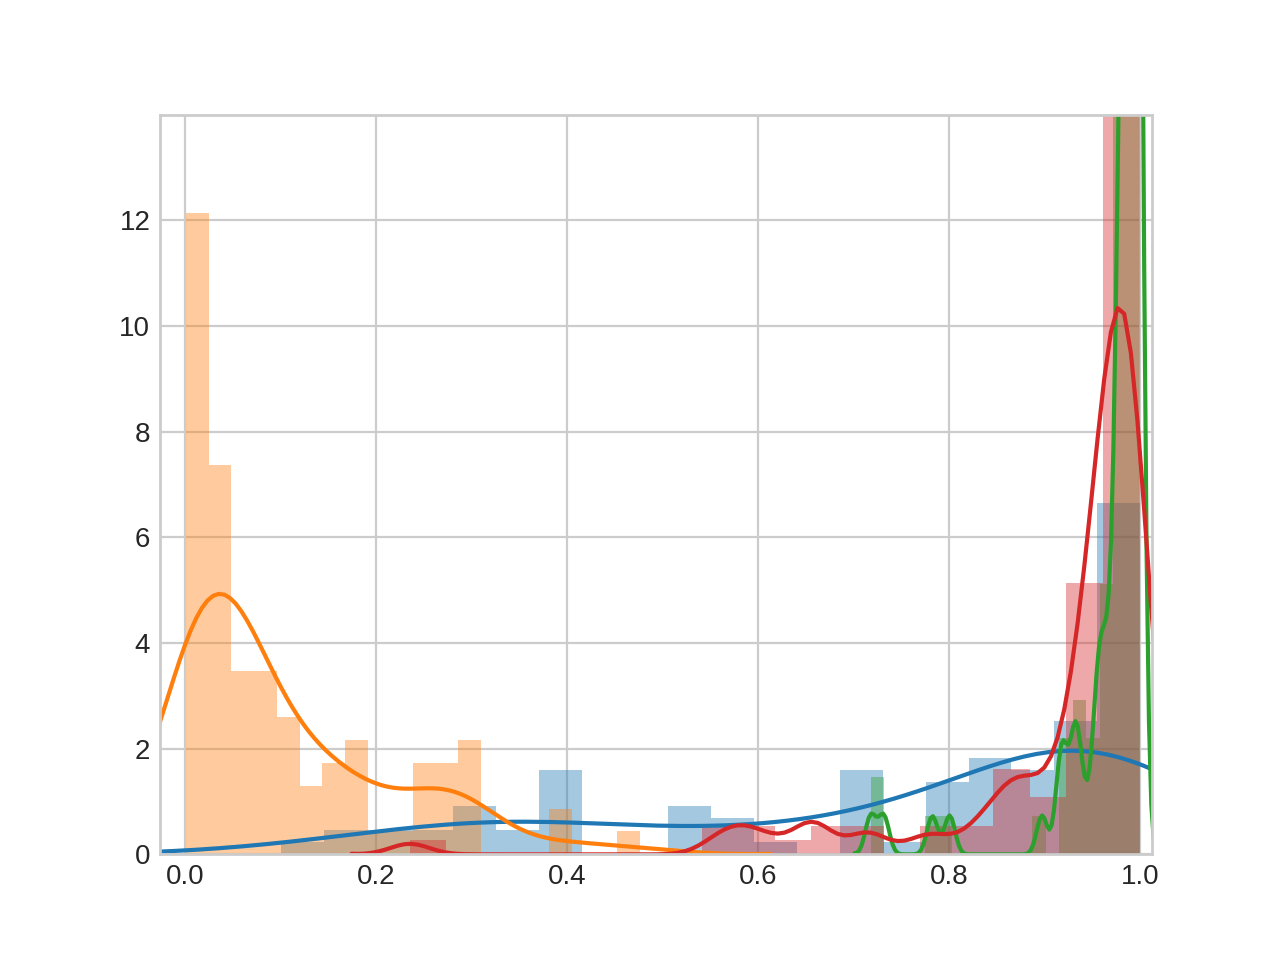

<AxesSubplot:>

In [119]:
# Density Plot and Histogram of all arrival delays
sns.distplot(probs_hh, hist=True, kde=True, bins=20)
sns.distplot(probs_ha1, hist=True, kde=True, bins=20)
sns.distplot(probs_aa, hist=True, kde=True, bins=20)
sns.distplot(probs_aa_shuffled, hist=True, kde=True, bins=20)

<IPython.core.display.Javascript object>


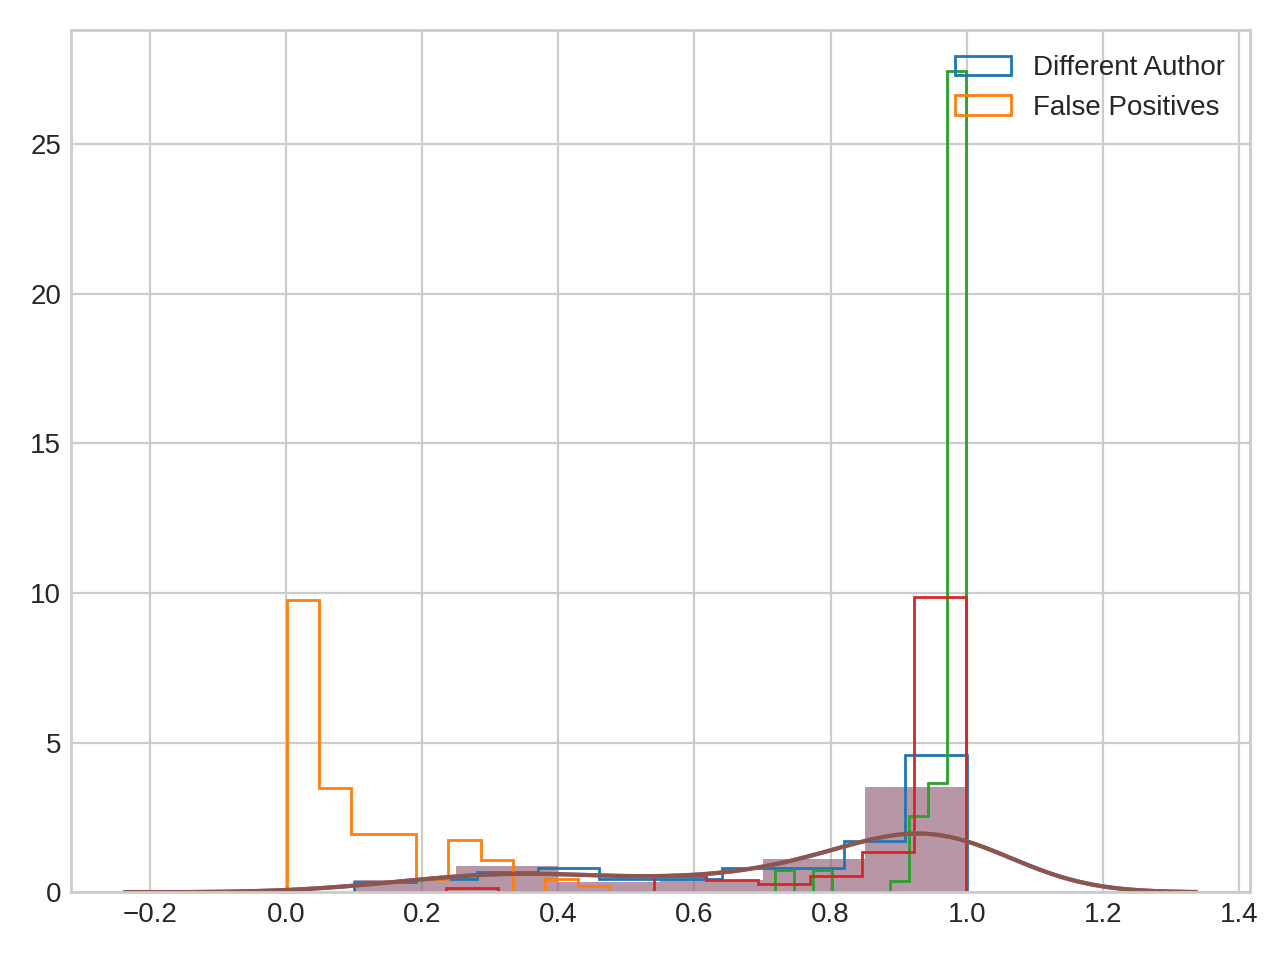

In [106]:


plt.hist(probs_hh, histtype='step', density=True)
plt.hist(probs_ha1, histtype='step', density=True)
plt.hist(probs_aa, histtype='step', fc='none', density=True)
plt.hist(probs_aa_shuffled, histtype='step', fc='none', density=True)

plt.legend(labels=['Different Author','False Positives'], loc='upper right')




plt.tight_layout()

plt.show()



In [16]:
style.use('seaborn-whitegrid')

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = [ 'Times New Roman', 'Times', 'DejaVu Serif',
 'Bitstream Vera Serif',
 'Computer Modern Roman',
 'New Century Schoolbook',
 'Century Schoolbook L',
 'Utopia',
 'ITC Bookman',
 'Bookman',
 'Nimbus Roman No9 L',
 'Palatino',
 'Charter',
 'serif']
rcParams['font.size']=7

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  

<IPython.core.display.Javascript object>


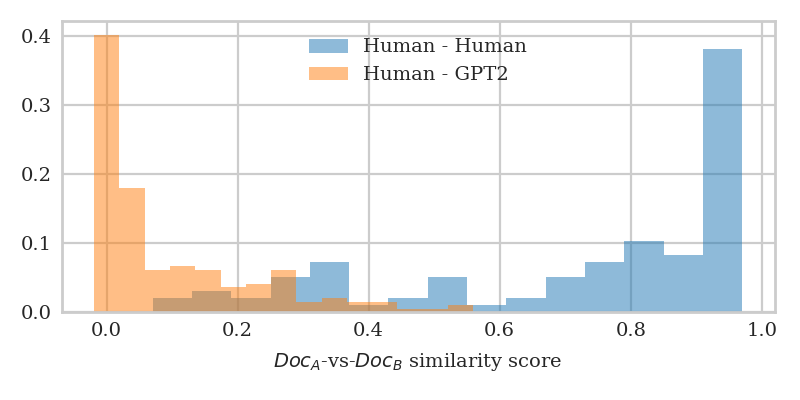

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))

nbins = 15
arr = probs_hh
results, edges = np.histogram(arr, density=True, bins=nbins)
binWidth = edges[1] - edges[0]
_ = ax.bar(edges[:-1], results * binWidth, binWidth, alpha=0.5,  color=colors[0])

arr = probs_ha
results, edges = np.histogram(arr, density=True, bins=nbins)
binWidth = edges[1] - edges[0]
_ = ax.bar(edges[:-1], results * binWidth, binWidth, alpha=0.5,  color=colors[1])
# _ = ax[0].hist(aggr_score[labels==False], bins=500, alpha=0.5)
ax.set_xlabel('$Doc_A$-vs-$Doc_B$ similarity score')
ax.legend(labels=['Human - Human', 'Human - GPT2'], loc='best')
# ax.title.set_text('Single Document Pair Model')


plt.tight_layout()

<IPython.core.display.Javascript object>


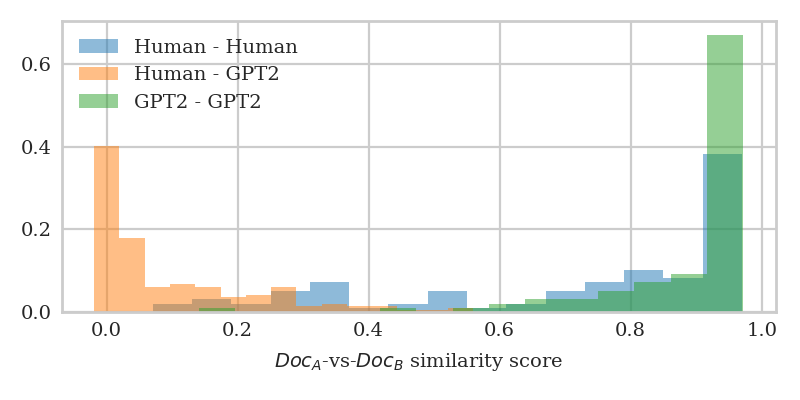

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))

nbins = 15
arr = probs_hh
results, edges = np.histogram(arr, density=True, bins=nbins)
binWidth = edges[1] - edges[0]
_ = ax.bar(edges[:-1], results * binWidth, binWidth, alpha=0.5,  color=colors[0])

arr = probs_ha
results, edges = np.histogram(arr, density=True, bins=nbins)
binWidth = edges[1] - edges[0]
_ = ax.bar(edges[:-1], results * binWidth, binWidth, alpha=0.5,  color=colors[1])
# _ = ax[0].hist(aggr_score[labels==False], bins=500, alpha=0.5)
# ax.title.set_text('Single Document Pair Model')

arr = probs_aa_shuffled
results, edges = np.histogram(arr, density=True, bins=nbins)
binWidth = edges[1] - edges[0]
_ = ax.bar(edges[:-1], results * binWidth, binWidth, alpha=0.5,  color=colors[2])
# _ = ax[0].hist(aggr_score[labels==False], bins=500, alpha=0.5)
ax.set_xlabel('$Doc_A$-vs-$Doc_B$ similarity score')
ax.legend(labels=['Human - Human', 'Human - GPT2', 'GPT2 - GPT2'], loc='best')

plt.tight_layout()